In [1]:
import os
import os.path as osp
import pandas as pd
import numpy as np
import collections
from snorkel import SnorkelSession
from tcre import supervision
from tcre.env import *
from tcre.supervision import *
session = SnorkelSession()
classes = get_candidate_classes()

REL_INDCK, REL_SECCK, REL_INDTF = 'indck', 'secck', 'indtf'
REL_ABBRS = collections.OrderedDict([
    (REL_INDCK, REL_CLASS_INDUCING_CYTOKINE),
    (REL_SECCK, REL_CLASS_SECRETED_CYTOKINE),
    (REL_INDTF, REL_CLASS_INDUCING_TRANSCRIPTION_FACTOR),
])

In [2]:
from snorkel.models import Candidate
c = session.query(classes.inducing_cytokine.subclass).first()
c.get_cids(), c.cytokine_cid, c.immune_cell_type_cid

(('CK692CB9564F9067B0:CK6004F9DA69B8AB01',
  'CT954E3C2D0B390922:CTE9F6070561C95355'),
 'CK692CB9564F9067B0:CK6004F9DA69B8AB01',
 'CT954E3C2D0B390922:CTE9F6070561C95355')

In [3]:
import re
from snorkel.lf_helpers import (
    get_tagged_text,
    get_left_tokens,
    get_right_tokens,
    get_between_tokens,
    get_text_splits,
    rule_regex_search_tagged_text,
    rule_regex_search_btw_AB,
    rule_regex_search_btw_BA,
    rule_regex_search_before_A,
    rule_regex_search_before_B,
)

In [4]:
#get_tagged_text(c) 

### Text Pattern Functions

In [5]:
TERMS = get_terms_map()

def subst_pattern(pattern, terms=None):
    for k, v in {**TERMS, **(terms or {})}.items():
        pattern = pattern.replace('{{' + k + '}}', v)
    return pattern

def regex_pattern(pattern, terms=None):
    return regex_search(None, pattern, terms=terms, pattern_only=True)
    
def regex_search(c, pattern, terms=None, pattern_only=False):
    # Add possible "cell" token after each cell type reference
    pattern = pattern.replace('{{B}}', '{{B}}( cell| type cell|-type cell)?')
    
    # Apply generic replacements in pattern
    pattern = subst_pattern(pattern, terms=terms)
    
    if pattern_only:
        return pattern
    return rule_regex_search_tagged_text(c, pattern, 1)

TERMS

{'r_diff_n': '(differentiation|formation|generation|polarization|development|induction)',
 'r_diff_v': '(differentiate|form|generate|polarize|develop|differentiates|forms|generates|polarizes|develops)',
 'r_diff_p': '(differentiated|formed|generated|polarized|developed)',
 'r_diff_g': '(differentiating|forming|generating|polarizing|developing)',
 'r_push_n': '(inducer|driver|director|regulator|controller|promoter|mediator|mediater)',
 'r_push_v': '(induce|drive|direct|regulate|control|promote|mediate|induces|drives|directs|regulates|controls|promotes|mediates)',
 'r_push_p': '(induced|drove|driven|directed|regulated|controlled|promoted|mediated)',
 'r_push_g': '(inducing|driving|directing|regulating|controlling|promoting|mediating)',
 'r_prod_n': '(producer|production|generator|generation|creator|creation)',
 'r_prod_v': '(produce|generate|create|produces|generates|creates)',
 'r_prod_p': '(produced|generated|created)',
 'r_prod_g': '(producing|generating|creating)',
 'r_secr_n': '(sec

In [6]:
# LF_REGEX[REL_CLASS_INDUCING_CYTOKINE]['positive'][23]

In [7]:
def add_lf(fn, name=None):
    if name is not None:
        fn.__name__ = name
    # Register function in global namespace
    globals()[fn.__name__] = fn
        
def get_fn(ptn, sign):
    sub_ptn = regex_search(c, ptn[0], terms=ptn[1] if len(ptn)>1 else None, pattern_only=True)
    def fn(c):
        return sign * regex_search(c, ptn[0], terms=ptn[1] if len(ptn)>1 else None)
    return fn, sub_ptn

def get_agg_fn(ptns, sign, agg):
    fns = [get_fn(ptn, sign)[0] for ptn in ptns]
    def fn(c):
        return agg([f(c) for f in fns])
    return fn

# Set to true to roll all text pattern functions into a single function 
# (since there can be > 30 of them)
use_single_text_pattern_fn = True
if use_single_text_pattern_fn:
    for rcls in LF_REGEX:
        cmap = {v: k for k, v in REL_ABBRS.items()}
        for sign in LF_REGEX[rcls]:
            val = {'positive': 1, 'negative': -1}[sign]
            ptns = LF_REGEX[rcls][sign]
            if len(ptns) == 0:
                continue
            agg = max if val == 1 else min
            add_lf(get_agg_fn(ptns, val, agg), 'LF_{}_txtptn_{}_all'.format(cmap[rcls], sign[:3]))
else:
    for rcls in LF_REGEX:
        cmap = {v: k for k, v in REL_ABBRS.items()}
        for sign in LF_REGEX[rcls]:
            for i, ptn in enumerate(LF_REGEX[rcls][sign]):
                val = {'positive': 1, 'negative': -1}[sign]
                fn_name = 'LF_{}_txtptn_{}_{}'.format(cmap[rcls], sign[:3], i + 1)
                fn, sub_ptn = get_fn(ptn, val)
                print(fn_name, ':\n\t', ptn[0], '\n\t', sub_ptn)
                add_lf(fn, fn_name)


In [8]:
# text = 'The current {{A}}-(pos) cells'
# pattern = regex_pattern(r'{{A}}(\+|-)?(positive|negative|\(pos\)|neg|hi|lo)')
# print(pattern)
# m = re.search(pattern, text, flags=re.I)
# m is not None, m

### Heuristic Functions

In [9]:
# Universal function to check for references that are over a certain number of words away, 
# making them unlikely to have any kind of relationship
def is_ref_too_far(c, max_words=25, allow_positive=False):
    n = len(list(get_between_tokens(c)))
    alt = 1 if allow_positive else 0
    return -1 if n > max_words else alt

def _add_dist_fn(abbr, dist_wrd):
    add_lf(
        lambda c: is_ref_too_far(c, dist_wrd, allow_positive=True), 
        'LF_' + abbr + '_heur_distref_' + str(dist_wrd)
    )
    
for abbr in REL_ABBRS:
    add_lf(lambda c: is_ref_too_far(c), 'LF_' + abbr + '_heur_distref')
    for dist_wrd in [5, 10, 15, 20, 25, 32, 50]:
        _add_dist_fn(abbr, dist_wrd)

def get_kwds(term_prefixes):
    return set([ 
        kw
        for prefix in term_prefixes
        for k, v in TERMS.items() if k.startswith(prefix)
        for kw in re.findall('\w+', v)
    ])

INDCK_KWS = get_kwds(['r_diff'])
SECCK_KWS = get_kwds(['r_secr'])
INDTF_KWS = get_kwds(['r_diff'])
INDCK_KWS = INDCK_KWS.difference(SECCK_KWS)
SECCK_KWS = SECCK_KWS.difference(INDCK_KWS)

             
def has_kwds(c, kwds, window=5):
    words = list(get_left_tokens(c, window=window)) + list(get_between_tokens(c)) + list(get_right_tokens(c, window=window))
    return len(kwds.intersection(words)) > 0

def indck_kwds(c, window):
    f1, f2 = has_kwds(c, INDCK_KWS, window=window), has_kwds(c, SECCK_KWS, window=window)
    if f1 and not f2:
        return 1
    if f2 and not f1:
        return -1
    return 0

def LF_indck_heur_kwds_01(c):
    return indck_kwds(c, 5)

def LF_indck_heur_kwds_02(c):
    return indck_kwds(c, 10)

def LF_indck_heur_kwds_03(c):
    return indck_kwds(c, 25)
    
def LF_secck_heur_kwds_01(c):
    return -1 * LF_indck_heur_kwds_01(c)

def LF_secck_heur_kwds_02(c):
    return -1 * LF_indck_heur_kwds_02(c)

def LF_secck_heur_kwds_03(c):
    return -1 * LF_indck_heur_kwds_03(c)

def LF_indtf_heur_kwds_01(c):
    return 1 if has_kwds(c, INDTF_KWS, window=5) else -1

def LF_indtf_heur_kwds_02(c):
    return 1 if has_kwds(c, INDTF_KWS, window=10) else -1

def LF_indtf_heur_kwds_03(c):
    return 1 if has_kwds(c, INDTF_KWS, window=25) else -1
        
def LF_indck_heur_closer_ck_to_ct(c):
    return -1*has_closer_reference(c, right=True)

def LF_indck_heur_closer_ct_to_ck(c):
    return -1*has_closer_reference(c, right=False)

def LF_indck_heur_closer_ref(c):
    return min(LF_indck_heur_closer_ck_to_ct(c), LF_indck_heur_closer_ct_to_ck(c))

def LF_secck_heur_closer_ck_to_ct(c):
    return -1*has_closer_reference(c, right=True)

def LF_secck_heur_closer_ct_to_ck(c):
    return -1*has_closer_reference(c, right=False)

def LF_secck_heur_closer_ref(c):
    return min(LF_secck_heur_closer_ck_to_ct(c), LF_secck_heur_closer_ct_to_ck(c))

def LF_indtf_heur_closer_tf_to_ct(c):
    return -1*has_closer_reference(c, right=True)

def LF_indtf_heur_closer_ct_to_tf(c):
    return -1*has_closer_reference(c, right=False)

def LF_indtf_heur_closer_ref(c):
    return min(LF_indtf_heur_closer_tf_to_ct(c), LF_indtf_heur_closer_ct_to_tf(c))


### Heuristics for identifying off-target sentences 

def _valid_cand(**kwargs):
    return lambda c: -1 if supervision.is_invalid_candidate(c, **kwargs) else 0

def _cmplx_cand(**kwargs):
    return lambda c: -1 if supervision.is_complex_candidate(c, **kwargs) else 0

def _hypot_cand(**kwargs):
    return lambda c: -1 if supervision.is_hypothesis_candidate(c, **kwargs) else 0

def _prexp_cand(**kwargs):
    return lambda c: -1 if supervision.is_expressed_protein(c, **kwargs) else 0

for abbr in REL_ABBRS:
    add_lf(_valid_cand(fig_kw_ct_thresh=1, punc_ct_thresh=5, newline_ct_thresh=3, char_ct_thresh=2000), 'LF_' + abbr + '_heur_valid_cand_01')
    add_lf(_valid_cand(fig_kw_ct_thresh=2, punc_ct_thresh=8, newline_ct_thresh=8, char_ct_thresh=2000), 'LF_' + abbr + '_heur_valid_cand_02')
    add_lf(_valid_cand(fig_kw_ct_thresh=4, punc_ct_thresh=12, newline_ct_thresh=10, char_ct_thresh=2000), 'LF_' + abbr + '_heur_valid_cand_03')
    add_lf(_cmplx_cand(entity_ct_thresh=3, char_ct_thresh=500), 'LF_' + abbr + '_heur_complex_cand_01')
    add_lf(_cmplx_cand(entity_ct_thresh=5, char_ct_thresh=800), 'LF_' + abbr + '_heur_complex_cand_02')
    add_lf(_hypot_cand(prefix_ct_thresh=1, token_ct_thresh=1), 'LF_' + abbr + '_heur_hypothesis_cand_01')
    add_lf(_hypot_cand(prefix_ct_thresh=1, token_ct_thresh=3), 'LF_' + abbr + '_heur_hypothesis_cand_02')
    if abbr != REL_SECCK:
        add_lf(_prexp_cand(), 'LF_' + abbr + '_heur_prexpression_cand_01')
    
### Heuristics for dependency parse tree processing

dep_parser = supervision.DependencyParseTree()

def LF_indck_parse_tree_01(c):
    if c.type != REL_FIELD_INDUCING_CYTOKINE:
        raise ValueError(f'Type {c.type} not supported')
    f1 = dep_parser.is_candidate_relation(c, REL_FIELD_INDUCING_CYTOKINE)
    f2 = dep_parser.is_candidate_relation(c, REL_FIELD_SECRETED_CYTOKINE)
    # Return false if heuristic positive for both related classes
    if f1 and f2:
        return -1
    return 1 if f1 else -1

def LF_secck_parse_tree_01(c):
    if c.type != REL_FIELD_SECRETED_CYTOKINE:
        raise ValueError(f'Type {c.type} not supported')
    f1 = dep_parser.is_candidate_relation(c, REL_FIELD_INDUCING_CYTOKINE)
    f2 = dep_parser.is_candidate_relation(c, REL_FIELD_SECRETED_CYTOKINE)
    # Return false if heuristic positive for both related classes
    if f1 and f2:
        return -1
    return 1 if f2 else -1

def LF_indtf_parse_tree_01(c):
    if c.type != REL_FIELD_INDUCING_TRANSCRIPTION_FACTOR:
        raise ValueError(f'Type {c.type} not supported')
    return 1 if dep_parser.is_candidate_relation(c, REL_FIELD_INDUCING_TRANSCRIPTION_FACTOR) else -1

### Distant Supervision Functions

In [10]:
from tcre.ix import IXDB
ix_data_file = osp.join(SUPERVISION_DATA_DIR, 'immunexpresso', 'data.csv')

def add_ix_lfs(ix, lf_suffix):
    
    def indck_fn(c):
        if c.type != classes.inducing_cytokine.field:
            return 0
        ind1 = ix.is_candidate_relation(c, 'cytokine', 'Positive')
        if ind1 is None:
            return 0
        ind2 = ix.is_candidate_relation(c, 'cytokine', 'Negative')
        ind3 = ix.is_candidate_relation(c, 'cell', 'Positive')
        if ind1:
            if not ind2 and not ind3:
                return 1
        else:
            if ind2 or ind3:
                return -1
        return 0

    def secck_fn(c):
        if c.type != classes.secreted_cytokine.field:
            return 0
        ind1 = ix.is_candidate_relation(c, 'cell', 'Positive')
        if ind1 is None:
            return 0
        ind2 = ix.is_candidate_relation(c, 'cytokine', 'Positive')
        ind3 = ix.is_candidate_relation(c, 'cytokine', 'Negative')
        if ind1:
            if not ind2 and not ind3:
                return 1
        else:
            if ind2 or ind3:
                return -1
        return 0
    
    add_lf(indck_fn, 'LF_indck_dsup_imexpresso_' + lf_suffix)
    add_lf(secck_fn, 'LF_secck_dsup_imexpresso_' + lf_suffix)
    
ixs = {}
for min_papers in [4, 8, 12, 20]:
    ixs[min_papers] = IXDB(ix_data_file, min_papers).initialize()
    add_ix_lfs(ixs[min_papers], f'mp{min_papers:02d}')
ixs[4].df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 157 entries, (CT00B5D38A1594A953, CK25044A239340F089) to (CTFE4015328B70D553, CKF8C95AB8BB638BAC)
Data columns (total 8 columns):
actor             157 non-null object
category          157 non-null object
cell_id           157 non-null object
cell_label        157 non-null object
cytokine_id       157 non-null object
cytokine_label    157 non-null object
num_papers        157 non-null int64
score             157 non-null float64
dtypes: float64(1), int64(1), object(6)
memory usage: 10.6+ KB


In [11]:
# df_ix = ixs[4].df
# dft = df_ix[(df_ix['actor'] == 'cell') & (df_ix['category'] == 'Positive')].sort_values('num_papers', ascending=False)
# dft[dft['cell_label'] == 'T-helper 2 cell'].head(10)

### Supervised Classifier Functions

In [12]:
# df_sup_pred = pd.read_csv(osp.join(RESULTS_DATA_DIR, 'training-dev', 'run1', 'predictions.csv'))
# df_sup_pred.info()

In [13]:
# OFFTARGET_SPLITS = collections.defaultdict(lambda: [])

# def get_base_sup_fn(task, cfg):
#     preds = df_sup_pred.pipe(lambda df: df[(df['cfg'] == cfg) & (df['task'] == task)]).set_index('id')['y_pred'].to_dict()
#     def fn(c):
#         if c.type != task and c.type not in COMP_CLASSES:
#             raise ValueError(f'Expected type {task} but got candidate {c} with type {c.type}')
#         # If the type of the candidate does not match that expected, then
#         # fetch the sibling candidate which should be of the correct type
#         # (this allows for example, the function to fetch SCK labels
#         # to accept an ICK candidate, convert to SCK, and then return that label instead)
#         if c.type != task:
#             sc = get_cand_sibling(c, strict=True)
#             if sc.type != task:
#                 raise ValueError(f'Sibling candidate {sc} of type {sc.type} does not match task {task} (original candidate = {c})')
#             # If the sibling ends up being in a split for which no predictions were made (e.g. INFER)
#             # record the id and abstain
#             if sc.id not in preds:
#                 OFFTARGET_SPLITS[task].append(sc.id)
#                 return 0
#             c = sc
#         if c.id not in preds:
#             raise ValueError(f'Failed to find prediction for candidate {c.id} for task {task} and model cfg {cfg}')
#         return 1 if preds[c.id] > .5 else -1
#     return fn

# for k, v in REL_ABBRS.items():
#     for cfg in df_sup_pred['cfg'].unique():
#         fn = get_base_sup_fn(classes[v].field, cfg)
#         add_lf(fn, f'LF_{k}_sup_cfg_{cfg:02d}')

In [14]:
# c = session.query(classes.inducing_transcription_factor.subclass).first()
# LF_indtf_sup_cfg_00(c)

### Composite Functions

In [15]:
def _global_lfs():
    return {
        k:v for k, v in globals().items() 
        if callable(v) and k.startswith('LF_')
    }

def get_lfs(filter_fn=None): 
    lfs = _global_lfs()
    if filter_fn is None:
        filter_fn = lambda n: True
    res = collections.OrderedDict([
        (k, lfs[k]) for k in sorted(lfs.keys()) 
        if filter_fn(k)
    ])
    return res

fns_indck_comp_pos = get_lfs(lambda k: k.startswith('LF_indck_txtptn_pos'))
fns_secck_comp_pos = get_lfs(lambda k: k.startswith('LF_secck_txtptn_pos'))
fns_indtf_comp_pos = get_lfs(lambda k: k.startswith('LF_indtf_txtptn_pos'))

def summarize_fns(name, fns):
    print('{}: Num functions found = {}, Names:\n{}'.format(
        name, len(fns), '\n'.join(list(fns.keys()))
    ))
summarize_fns('fns_indck_comp_pos', fns_indck_comp_pos)
summarize_fns('fns_secck_comp_pos', fns_secck_comp_pos)
summarize_fns('fns_indtf_comp_pos', fns_indtf_comp_pos)

def LF_indck_comp_neg_sec(c):
    # Create function that returns -1 for inducing cytokines anytime a positive hit is found on secretion
    # * should return -1 or 0
    return min(-1*max([f(c) for f in fns_secck_comp_pos.values()]), 0)

def LF_secck_comp_neg_ind(c):
    # Create function that returns -1 for inducing cytokines anytime a positive hit is found on secretion
    # * should return -1 or 0
    return min(-1*max([f(c) for f in fns_indck_comp_pos.values()]), 0)

fns_indck_comp_neg = get_lfs(lambda k: k.startswith('LF_indck_txtptn_neg') or \
                             k.startswith('LF_indck_heur_distref') or \
                             k.startswith('LF_indck_heur_closer_ct_to_ck') or \
                             k.startswith('LF_indck_comp_neg_sec') or \
                             k.startswith('LF_indck_heur_complex_cand_02') or \
                             k.startswith('LF_indck_heur_valid_cand_03'))
fns_secck_comp_neg = get_lfs(lambda k: k.startswith('LF_secck_txtptn_neg') or \
                             k.startswith('LF_secck_heur_distref') or \
                             k.startswith('LF_secck_heur_closer_ct_to_ck') or \
                             k.startswith('LF_secck_comp_neg_ind') or \
                             k.startswith('LF_secck_heur_complex_cand_02') or \
                             k.startswith('LF_secck_heur_valid_cand_03'))
fns_indtf_comp_neg = get_lfs(lambda k: k.startswith('LF_indtf_txtptn_neg') or \
                             k.startswith('LF_indtf_heur_distref') or \
                             k.startswith('LF_indtf_heur_closer_ct_to_tf') or \
                             k.startswith('LF_indtf_heur_complex_cand_02') or \
                             k.startswith('LF_indtf_heur_valid_cand_03'))
summarize_fns('fns_indck_comp_neg', fns_indck_comp_neg)
summarize_fns('fns_secck_comp_neg', fns_secck_comp_neg)
summarize_fns('fns_indtf_comp_neg', fns_indtf_comp_neg)

def apply_composite_xor_indck(c):
    is_secck = max([f(c) for f in fns_secck_comp_pos.values()]) > 0
    is_indck = max([f(c) for f in fns_indck_comp_pos.values()]) > 0
    not_secck = min([f(c) for f in fns_secck_comp_neg.values()]) < 0
    not_indck = min([f(c) for f in fns_indck_comp_neg.values()]) < 0
    # Look first for single strong positive prediction
    if is_secck and is_indck:
        return 0
    if is_indck and not is_secck:
        return 1
    if not is_indck and is_secck:
        return -1
    # If neither have positive prediction, look for strong negative prediction
    if not_secck == not_indck:
        return 0
    if not_indck and not not_secck:
        return -1
    return 1

def LF_indck_comp_xor(c):
    return apply_composite_xor_indck(c)

def LF_secck_comp_xor(c):
    return -1*apply_composite_xor_indck(c)

def LF_indtf_comp_xor(c):
    is_indtf = max([f(c) for f in fns_indtf_comp_pos.values()]) > 0
    not_indtf = min([f(c) for f in fns_indtf_comp_neg.values()]) < 0
    # Take non-conflicting positive or negative classifications and make 0 otherwise
    if is_indtf and not not_indtf:
        return 1
    if not_indtf and not is_indtf:
        return -1
    return 0

# Distant supervision composites
def LF_indck_comp_imexpresso_nonneg(c):
    skip = min([f(c) for f in fns_indck_comp_neg.values()]) < 0
    return LF_indck_dsup_imexpresso_mp08(c) if not skip else 0

def LF_secck_comp_imexpresso_nonneg(c):
    skip = min([f(c) for f in fns_secck_comp_neg.values()]) < 0
    return LF_secck_dsup_imexpresso_mp08(c) if not skip else 0

# Direct supervision composites
# fns_indck_sup = get_lfs(lambda k: k.startswith('LF_indck_sup_cfg_'))
# fns_secck_sup = get_lfs(lambda k: k.startswith('LF_secck_sup_cfg_'))
# fns_indtf_sup = get_lfs(lambda k: k.startswith('LF_indtf_sup_cfg_'))
# summarize_fns('fns_indck_sup', fns_indck_sup)
# summarize_fns('fns_secck_sup', fns_secck_sup)
# summarize_fns('fns_indtf_sup', fns_indtf_sup)

# def LF_indck_sup_comp(c):
#     # If there is any strong indication of a negative, use it instead
#     not_indck = min([f(c) for f in fns_indck_comp_neg.values()]) < 0
#     if not_indck:
#         return -1
    
#     # Return false if any supervised model predicts true for secreted cytokines
#     is_secck = max([f(c) for f in fns_secck_sup.values()]) > 0
#     if is_secck:
#         return -1

#     # Otherwise, return true if any model predicts true
#     is_indck = max([f(c) for f in fns_indck_sup.values()]) > 0
#     return 1 if is_indck else -1

# def LF_secck_sup_comp(c):
#     # If there is any strong indication of a negative, use it instead
#     not_secck = min([f(c) for f in fns_secck_comp_neg.values()]) < 0
#     if not_secck:
#         return -1
    
#     # Return false if any supervised model predicts true for inducing cytokines
#     is_indck = max([f(c) for f in fns_indck_sup.values()]) > 0
#     if is_indck:
#         return -1
    
#     # Otherwise, return true if any model predicts true
#     is_secck = max([f(c) for f in fns_secck_sup.values()]) > 0
#     return 1 if is_secck else -1

# def LF_indtf_sup_comp(c):
#     # Return true if any model predicts true
#     is_indtf = max([f(c) for f in fns_indtf_sup.values()]) > 0
#     return 1 if is_indtf else -1

fns_indck_comp_pos: Num functions found = 1, Names:
LF_indck_txtptn_pos_all
fns_secck_comp_pos: Num functions found = 1, Names:
LF_secck_txtptn_pos_all
fns_indtf_comp_pos: Num functions found = 1, Names:
LF_indtf_txtptn_pos_all
fns_indck_comp_neg: Num functions found = 13, Names:
LF_indck_comp_neg_sec
LF_indck_heur_closer_ct_to_ck
LF_indck_heur_complex_cand_02
LF_indck_heur_distref
LF_indck_heur_distref_10
LF_indck_heur_distref_15
LF_indck_heur_distref_20
LF_indck_heur_distref_25
LF_indck_heur_distref_32
LF_indck_heur_distref_5
LF_indck_heur_distref_50
LF_indck_heur_valid_cand_03
LF_indck_txtptn_neg_all
fns_secck_comp_neg: Num functions found = 13, Names:
LF_secck_comp_neg_ind
LF_secck_heur_closer_ct_to_ck
LF_secck_heur_complex_cand_02
LF_secck_heur_distref
LF_secck_heur_distref_10
LF_secck_heur_distref_15
LF_secck_heur_distref_20
LF_secck_heur_distref_25
LF_secck_heur_distref_32
LF_secck_heur_distref_5
LF_secck_heur_distref_50
LF_secck_heur_valid_cand_03
LF_secck_txtptn_neg_all
fns_in

In [16]:
LFs = collections.OrderedDict()
LFs[REL_CLASS_INDUCING_CYTOKINE] = get_lfs(lambda k: k.startswith('LF_indck')).values()
LFs[REL_CLASS_SECRETED_CYTOKINE] = get_lfs(lambda k: k.startswith('LF_secck')).values()
LFs[REL_CLASS_INDUCING_TRANSCRIPTION_FACTOR] = get_lfs(lambda k: k.startswith('LF_indtf')).values()
for k in LFs:
    print('{} labeling functions:'.format(k))
    for f in LFs[k]:
        print(f.__name__)
    print()

InducingCytokine labeling functions:
LF_indck_comp_imexpresso_nonneg
LF_indck_comp_neg_sec
LF_indck_comp_xor
LF_indck_dsup_imexpresso_mp04
LF_indck_dsup_imexpresso_mp08
LF_indck_dsup_imexpresso_mp12
LF_indck_dsup_imexpresso_mp20
LF_indck_heur_closer_ck_to_ct
LF_indck_heur_closer_ct_to_ck
LF_indck_heur_closer_ref
LF_indck_heur_complex_cand_01
LF_indck_heur_complex_cand_02
LF_indck_heur_distref
LF_indck_heur_distref_10
LF_indck_heur_distref_15
LF_indck_heur_distref_20
LF_indck_heur_distref_25
LF_indck_heur_distref_32
LF_indck_heur_distref_5
LF_indck_heur_distref_50
LF_indck_heur_hypothesis_cand_01
LF_indck_heur_hypothesis_cand_02
LF_indck_heur_kwds_01
LF_indck_heur_kwds_02
LF_indck_heur_kwds_03
LF_indck_heur_prexpression_cand_01
LF_indck_heur_valid_cand_01
LF_indck_heur_valid_cand_02
LF_indck_heur_valid_cand_03
LF_indck_parse_tree_01
LF_indck_txtptn_neg_all
LF_indck_txtptn_pos_all

SecretedCytokine labeling functions:
LF_secck_comp_imexpresso_nonneg
LF_secck_comp_neg_ind
LF_secck_comp_xo

#### LF Testing

In [17]:
# from snorkel.viewer import SentenceNgramViewer
# from snorkel.annotations import load_gold_labels

# candidate_class = classes.inducing_cytokine
# #candidate_class = classes.secreted_cytokine
# #candidate_class = classes.inducing_transcription_factor
# # Load all dev labels for this relation class
# L_dev = supervision.get_gold_labels(session, candidate_class, split=SPLIT_DEV)

# labeled, gold = [], []
# for cand_id, v in L_dev.items():
#     c = session.query(Candidate).filter(Candidate.id == cand_id).one()
#     if LF_indck_parse_tree_01(c) == 1:
#         labeled.append(c)
#         if v > 0:
#             gold.append(c)

# print("Number labeled =", len(labeled), ", num gold =", len(gold))
# # - ID in hover state is sentence id (c.get_parent().id)
# # - Cell type label will be blue if candidate is NOT in "gold" set and red otherwise
# SentenceNgramViewer(labeled, session, gold=gold, height=1000)

In [18]:
# from tcre.query import DocToCand
# sent_id = 325453
# df_doc_cand = DocToCand.all(session, classes)
# cand_ids = df_doc_cand.set_index(['cand_type', 'sentence_id']).sort_index().loc[(candidate_class.field, sent_id)]['cand_id']
# c = session.query(Candidate).filter(Candidate.id == int(cand_ids.values[0])).one()
# c

## Apply Labeling to Candidates

In [19]:
for c in classes.values():
    for split in [SPLIT_DEV, SPLIT_VAL, SPLIT_TEST, SPLIT_TRAIN, SPLIT_INFER]:
        n = session.query(c.subclass).filter(c.subclass.split == split).count()
        print('Candidate counts: {} (split {}) -> {}'.format(c.name, split, n))

Candidate counts: InducingCytokine (split 1) -> 950
Candidate counts: InducingCytokine (split 3) -> 203
Candidate counts: InducingCytokine (split 2) -> 271
Candidate counts: InducingCytokine (split 0) -> 10000
Candidate counts: InducingCytokine (split 9) -> 80415
Candidate counts: SecretedCytokine (split 1) -> 952
Candidate counts: SecretedCytokine (split 3) -> 205
Candidate counts: SecretedCytokine (split 2) -> 274
Candidate counts: SecretedCytokine (split 0) -> 10000
Candidate counts: SecretedCytokine (split 9) -> 80408
Candidate counts: InducingTranscriptionFactor (split 1) -> 612
Candidate counts: InducingTranscriptionFactor (split 3) -> 209
Candidate counts: InducingTranscriptionFactor (split 2) -> 281
Candidate counts: InducingTranscriptionFactor (split 0) -> 10000
Candidate counts: InducingTranscriptionFactor (split 9) -> 25433


In [20]:
# To remove all labels:
from snorkel.models import Label, LabelKey
session.query(Label).delete()
session.query(LabelKey).delete()
session.commit()

In [21]:
for c in [Label, LabelKey]:
    print(c.__name__, session.query(c).count())

Label 0
LabelKey 0


In [22]:
from snorkel.models import Candidate
from snorkel.annotations import LabelAnnotator
from snorkel.annotations import load_gold_labels

def run_labeling(candidate_class, lfs, split, replace_key_set=False, has_gold_labels=False):
    cids_query = get_cids_query(session, candidate_class, split)
    y = None
    if has_gold_labels:
        y = supervision.get_gold_labels(
            session, candidate_class, 
            split=split
        ).values
    
    print('Running labeling for class {}, split {}'.format(candidate_class.name, split))
    labeler = LabelAnnotator(lfs=lfs)
    X = labeler.apply(
        split=split, cids_query=cids_query, clear=False,
        replace_key_set=replace_key_set, key_group=candidate_class.index
    )
    stats = X.lf_stats(session, y)
    
    return X, y, stats, labeler

res_label = collections.defaultdict(dict)
for c in classes:
    if c not in LFs:
        continue
#     for i, split in enumerate([SPLIT_DEV]):
#     for i, split in enumerate([SPLIT_DEV, SPLIT_VAL, SPLIT_TEST]):
#     for i, split in enumerate([SPLIT_TRAIN]):
    for i, split in enumerate([SPLIT_DEV, SPLIT_VAL, SPLIT_TEST, SPLIT_TRAIN]):
        res_label[c][split] = run_labeling(
            classes[c], LFs[c], split, 
            replace_key_set=i == 0, # Set to false if other splits have already been labeled
            has_gold_labels=split in [SPLIT_DEV, SPLIT_VAL, SPLIT_TEST]
        )

  0%|          | 2/950 [00:00<01:22, 11.45it/s]

Running labeling for class InducingCytokine, split 1
Running UDF...


  1%|▏         | 3/203 [00:00<00:08, 24.04it/s]

Running labeling for class InducingCytokine, split 3
Running UDF...


  1%|          | 3/271 [00:00<00:10, 24.86it/s]

Running labeling for class InducingCytokine, split 2
Running UDF...


  0%|          | 2/10000 [00:00<12:11, 13.67it/s]

Running labeling for class InducingCytokine, split 0
Running UDF...


  0%|          | 3/952 [00:00<00:32, 29.30it/s]

Running labeling for class SecretedCytokine, split 1
Running UDF...


  1%|▏         | 3/205 [00:00<00:08, 24.24it/s]

Running labeling for class SecretedCytokine, split 3
Running UDF...


  1%|          | 3/274 [00:00<00:10, 25.15it/s]

Running labeling for class SecretedCytokine, split 2
Running UDF...


  0%|          | 3/10000 [00:00<06:13, 26.78it/s]

Running labeling for class SecretedCytokine, split 0
Running UDF...


  1%|          | 4/612 [00:00<00:17, 35.70it/s]

Running labeling for class InducingTranscriptionFactor, split 1
Running UDF...


  2%|▏         | 4/209 [00:00<00:05, 36.91it/s]

Running labeling for class InducingTranscriptionFactor, split 3
Running UDF...


  1%|▏         | 4/281 [00:00<00:07, 36.18it/s]

Running labeling for class InducingTranscriptionFactor, split 2
Running UDF...


  0%|          | 4/10000 [00:00<04:25, 37.59it/s]

Running labeling for class InducingTranscriptionFactor, split 0
Running UDF...


100%|██████████| 10000/10000 [05:38<00:00, 31.80it/s]


In [23]:
# [(k, len(set(v))) for k, v in OFFTARGET_SPLITS.items()]

In [24]:
def add_f1(df, eps=1e-8):
    if 'Empirical Acc.' in df:
        precision = df['TP'] / (df['TP'] + df['FP'])
        recall = df['TP'] / (df['TP'] + df['FN'])
        df['Empirical F1'] = (2 * precision * recall) / (precision + recall + eps)
    return df

In [39]:
from IPython.display import display
for c in res_label:
    for split in res_label[c]:
        if split not in [SPLIT_DEV, SPLIT_TRAIN]:
            continue
        print('Stats {} (split = {} ({})):'.format(c, SPLIT_MAP[split], split))
        df = add_f1(res_label[c][split][2])
        subset = ['Coverage'] + (['Empirical Acc.'] if 'Empirical Acc.' in df else [])
        display(df.style.background_gradient(subset=subset))

Stats InducingCytokine (split = dev (1)):


,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.,Empirical F1
LF_indck_comp_imexpresso_nonneg,0,0.02,0.02,0.02,1,2,0,16,0.894737,0.5
LF_indck_comp_neg_sec,1,0.115789,0.115789,0.114737,0,0,5,105,0.954545,nan
LF_indck_comp_xor,2,0.249474,0.249474,0.248421,63,67,3,104,0.704641,0.642857
LF_indck_dsup_imexpresso_mp04,3,0.202105,0.202105,0.195789,33,22,6,131,0.854167,0.702128
LF_indck_dsup_imexpresso_mp08,4,0.149474,0.149474,0.143158,16,13,3,110,0.887324,0.666667
LF_indck_dsup_imexpresso_mp12,5,0.131579,0.131579,0.125263,16,12,3,94,0.88,0.680851
LF_indck_dsup_imexpresso_mp20,6,0.110526,0.110526,0.1,16,12,9,68,0.8,0.603774
LF_indck_heur_closer_ck_to_ct,7,0.346316,0.346316,0.252632,0,0,34,295,0.896657,nan
LF_indck_heur_closer_ct_to_ck,8,0.258947,0.258947,0.161053,0,0,9,237,0.963415,nan
LF_indck_heur_closer_ref,9,0.425263,0.425263,0.318947,0,0,41,363,0.898515,nan


Stats InducingCytokine (split = train (0)):


,j,Coverage,Overlaps,Conflicts
LF_indck_comp_imexpresso_nonneg,0,0.0117,0.0117,0.0116
LF_indck_comp_neg_sec,1,0.1442,0.1442,0.1438
LF_indck_comp_xor,2,0.167,0.167,0.1662
LF_indck_dsup_imexpresso_mp04,3,0.2039,0.2039,0.1935
LF_indck_dsup_imexpresso_mp08,4,0.1358,0.1358,0.1271
LF_indck_dsup_imexpresso_mp12,5,0.1088,0.1088,0.1008
LF_indck_dsup_imexpresso_mp20,6,0.0905,0.0905,0.0862
LF_indck_heur_closer_ck_to_ct,7,0.2585,0.2585,0.2041
LF_indck_heur_closer_ct_to_ck,8,0.1912,0.1912,0.1484
LF_indck_heur_closer_ref,9,0.3445,0.3445,0.2843


Stats SecretedCytokine (split = dev (1)):


,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.,Empirical F1
LF_secck_comp_imexpresso_nonneg,0,0.0220588,0.0220588,0.0210084,6,12,0,3,0.428571,0.5
LF_secck_comp_neg_ind,1,0.141807,0.141807,0.141807,0,0,0,135,1,nan
LF_secck_comp_xor,2,0.25105,0.25105,0.24895,63,44,0,132,0.8159,0.741176
LF_secck_dsup_imexpresso_mp04,3,0.227941,0.227941,0.227941,43,83,3,88,0.603687,0.5
LF_secck_dsup_imexpresso_mp08,4,0.141807,0.141807,0.140756,25,84,0,26,0.377778,0.373134
LF_secck_dsup_imexpresso_mp12,5,0.127101,0.127101,0.12605,16,79,0,26,0.347107,0.288288
LF_secck_dsup_imexpresso_mp20,6,0.103992,0.103992,0.102941,17,56,0,26,0.434343,0.377778
LF_secck_heur_closer_ck_to_ct,7,0.346639,0.346639,0.277311,0,0,14,316,0.957576,nan
LF_secck_heur_closer_ct_to_ck,8,0.256303,0.256303,0.184874,0,0,3,241,0.987705,nan
LF_secck_heur_closer_ref,9,0.423319,0.423319,0.345588,0,0,17,386,0.957816,nan


Stats SecretedCytokine (split = train (0)):


,j,Coverage,Overlaps,Conflicts
LF_secck_comp_imexpresso_nonneg,0,0.02,0.02,0.0186
LF_secck_comp_neg_ind,1,0.025,0.025,0.025
LF_secck_comp_xor,2,0.1649,0.1649,0.1625
LF_secck_dsup_imexpresso_mp04,3,0.2184,0.2184,0.2133
LF_secck_dsup_imexpresso_mp08,4,0.128,0.128,0.1257
LF_secck_dsup_imexpresso_mp12,5,0.1079,0.1079,0.1059
LF_secck_dsup_imexpresso_mp20,6,0.0892,0.0892,0.0878
LF_secck_heur_closer_ck_to_ct,7,0.257,0.257,0.2203
LF_secck_heur_closer_ct_to_ck,8,0.2014,0.2014,0.1692
LF_secck_heur_closer_ref,9,0.3477,0.3477,0.3055


Stats InducingTranscriptionFactor (split = dev (1)):


,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.,Empirical F1
LF_indtf_comp_xor,0,0.789216,0.789216,0.771242,15,5,45,418,0.89648,0.375
LF_indtf_heur_closer_ct_to_tf,1,0.30719,0.30719,0.302288,0,0,1,187,0.994681,nan
LF_indtf_heur_closer_ref,2,0.385621,0.385621,0.375817,0,0,8,228,0.966102,nan
LF_indtf_heur_closer_tf_to_ct,3,0.20915,0.20915,0.204248,0,0,7,121,0.945312,nan
LF_indtf_heur_complex_cand_01,4,0.926471,0.926471,0.910131,0,0,91,476,0.839506,nan
LF_indtf_heur_complex_cand_02,5,0.70098,0.70098,0.684641,0,0,57,372,0.867133,nan
LF_indtf_heur_distref,6,0.218954,0.218954,0.202614,0,0,2,132,0.985075,nan
LF_indtf_heur_distref_10,7,1,1,0.980392,88,201,22,301,0.635621,0.441103
LF_indtf_heur_distref_15,8,1,1,0.980392,100,277,10,225,0.531046,0.410678
LF_indtf_heur_distref_20,9,1,1,0.980392,107,324,3,178,0.465686,0.395564


Stats InducingTranscriptionFactor (split = train (0)):


,j,Coverage,Overlaps,Conflicts
LF_indtf_comp_xor,0,0.773,0.773,0.7472
LF_indtf_heur_closer_ct_to_tf,1,0.1633,0.1633,0.1525
LF_indtf_heur_closer_ref,2,0.2569,0.2569,0.2405
LF_indtf_heur_closer_tf_to_ct,3,0.1452,0.1452,0.1343
LF_indtf_heur_complex_cand_01,4,0.8832,0.8832,0.8593
LF_indtf_heur_complex_cand_02,5,0.5269,0.5269,0.5038
LF_indtf_heur_distref,6,0.1749,0.1749,0.1508
LF_indtf_heur_distref_10,7,1,1,0.9739
LF_indtf_heur_distref_15,8,1,1,0.9739
LF_indtf_heur_distref_20,9,1,1,0.9739


## Train Generative Model

In [26]:
res_label.keys()

dict_keys(['InducingCytokine', 'SecretedCytokine', 'InducingTranscriptionFactor'])

In [27]:
from snorkel.learning.structure import DependencySelector
from snorkel.learning import GenerativeModel

res_train = {}
for c in res_label:
    print(f'Running generative model training for relation class {c}')
    ds = DependencySelector()
    X = res_label[c][SPLIT_TRAIN][0]
    deps = ds.select(X, threshold=0.1)
    gen_model = GenerativeModel(lf_propensity=True)
    gen_model.train(
        X, deps=deps, decay=0.95, 
        step_size=0.1/X.shape[0], reg_param=0.0
    )
    marginals = gen_model.marginals(X)
    res_train[c] = gen_model, X, marginals, deps

Running generative model training for class InducingCytokine
Inferred cardinality: 2
Running generative model training for class SecretedCytokine
Inferred cardinality: 2
Running generative model training for class InducingTranscriptionFactor
Inferred cardinality: 2


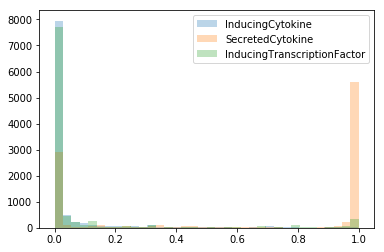

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
for c in res_train:
    plt.hist(res_train[c][2], bins=36, label=c, alpha=.3)
    plt.legend()

In [29]:
# from IPython.display import display
# for c in res_train:
#     print(c)
#     display(res_train[c][0].learned_lf_stats())

In [29]:
from snorkel.annotations import save_marginals

# Fetch the candidates for each class into a SINGLE list and do
# the same for the marginal arrays since the `save_marginals` function
# deletes all records (with no arguments for filters to avoid this) each time,
# making it impossible to call separately for each set of candidates
candidates, marginals = [], []
for c in res_train:
    X, y = res_train[c][1], res_train[c][2]
    candidates.extend([X.get_candidate(session, i) for i in range(X.shape[0])])
    marginals.append(y)
marginals = np.concatenate(marginals)
assert len(candidates) == len(marginals)
save_marginals(session, candidates, marginals)

Saved 30000 marginals


In [30]:
from snorkel.models import Marginal, Candidate

# Determine the candidate types for all saved marginals
cids = [m.candidate_id for m in session.query(Marginal).all()]
pd.DataFrame(
    session.query(Candidate.id, Candidate.type).filter(Candidate.id.in_(cids)),
    columns=['id', 'type']
).groupby('type').size()

type
inducing_cytokine                10000
inducing_transcription_factor    10000
secreted_cytokine                10000
dtype: int64

In [33]:
res_lf_stats = {}
for c in classes:
    print(c)
    candidate_class = classes[c]
    split = SPLIT_DEV
    L_dev = res_label[c][split][0]
    L_gold_dev = res_label[c][split][1]
    gen_model_train = res_train[c][0]
    gen_model_train.error_analysis(session, L_dev, L_gold_dev)
    res_lf_stats[c] = L_dev.lf_stats(session, L_gold_dev, gen_model_train.learned_lf_stats()['Accuracy'])
    display(res_lf_stats[c].style.background_gradient(subset=['Empirical Acc.', 'Learned Acc.']))

InducingCytokine
Scores (Un-adjusted)
Pos. class accuracy: 0.212
Neg. class accuracy: 0.969
Precision            0.537
Recall               0.212
F1                   0.304
----------------------------------------
TP: 29 | FP: 25 | TN: 788 | FN: 108



,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.,Learned Acc.
LF_indck_comp_imexpresso_nonneg,0,0.02,0.02,0.02,1,2,0,16,0.894737,0.222222
LF_indck_comp_neg_sec,1,0.115789,0.115789,0.114737,0,0,5,105,0.954545,0.611584
LF_indck_comp_xor,2,0.249474,0.249474,0.248421,63,67,3,104,0.704641,0.63307
LF_indck_dsup_imexpresso_mp04,3,0.202105,0.202105,0.195789,33,22,6,131,0.854167,0.572861
LF_indck_dsup_imexpresso_mp08,4,0.149474,0.149474,0.143158,16,13,3,110,0.887324,0.58445
LF_indck_dsup_imexpresso_mp12,5,0.131579,0.131579,0.125263,16,12,3,94,0.88,0.534196
LF_indck_dsup_imexpresso_mp20,6,0.110526,0.110526,0.1,16,12,9,68,0.8,0.498866
LF_indck_heur_closer_ck_to_ct,7,0.346316,0.346316,0.252632,0,0,34,295,0.896657,0.810721
LF_indck_heur_closer_ct_to_ck,8,0.258947,0.258947,0.161053,0,0,9,237,0.963415,0.742658
LF_indck_heur_closer_ref,9,0.425263,0.425263,0.318947,0,0,41,363,0.898515,0.863485


SecretedCytokine
Scores (Un-adjusted)
Pos. class accuracy: 0.92
Neg. class accuracy: 0.446
Precision            0.181
Recall               0.92
F1                   0.303
----------------------------------------
TP: 103 | FP: 465 | TN: 375 | FN: 9



,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.,Learned Acc.
LF_secck_comp_imexpresso_nonneg,0,0.0220588,0.0220588,0.0210084,6,12,0,3,0.428571,0.449541
LF_secck_comp_neg_ind,1,0.141807,0.141807,0.141807,0,0,0,135,1,0.216495
LF_secck_comp_xor,2,0.25105,0.25105,0.24895,63,44,0,132,0.8159,0.662086
LF_secck_dsup_imexpresso_mp04,3,0.227941,0.227941,0.227941,43,83,3,88,0.603687,0.54823
LF_secck_dsup_imexpresso_mp08,4,0.141807,0.141807,0.140756,25,84,0,26,0.377778,0.525
LF_secck_dsup_imexpresso_mp12,5,0.127101,0.127101,0.12605,16,79,0,26,0.347107,0.471756
LF_secck_dsup_imexpresso_mp20,6,0.103992,0.103992,0.102941,17,56,0,26,0.434343,0.496078
LF_secck_heur_closer_ck_to_ct,7,0.346639,0.346639,0.277311,0,0,14,316,0.957576,0.669704
LF_secck_heur_closer_ct_to_ck,8,0.256303,0.256303,0.184874,0,0,3,241,0.987705,0.629485
LF_secck_heur_closer_ref,9,0.423319,0.423319,0.345588,0,0,17,386,0.957816,0.68595


InducingTranscriptionFactor
Scores (Un-adjusted)
Pos. class accuracy: 0.327
Neg. class accuracy: 0.966
Precision            0.679
Recall               0.327
F1                   0.442
----------------------------------------
TP: 36 | FP: 17 | TN: 485 | FN: 74



,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.,Learned Acc.
LF_indtf_comp_xor,0,0.789216,0.789216,0.771242,15,5,45,418,0.89648,0.945593
LF_indtf_heur_closer_ct_to_tf,1,0.30719,0.30719,0.302288,0,0,1,187,0.994681,0.727348
LF_indtf_heur_closer_ref,2,0.385621,0.385621,0.375817,0,0,8,228,0.966102,0.798081
LF_indtf_heur_closer_tf_to_ct,3,0.20915,0.20915,0.204248,0,0,7,121,0.945312,0.731192
LF_indtf_heur_complex_cand_01,4,0.926471,0.926471,0.910131,0,0,91,476,0.839506,0.930324
LF_indtf_heur_complex_cand_02,5,0.70098,0.70098,0.684641,0,0,57,372,0.867133,0.920495
LF_indtf_heur_distref,6,0.218954,0.218954,0.202614,0,0,2,132,0.985075,0.766332
LF_indtf_heur_distref_10,7,1,1,0.980392,88,201,22,301,0.635621,0.740025
LF_indtf_heur_distref_15,8,1,1,0.980392,100,277,10,225,0.531046,0.463426
LF_indtf_heur_distref_20,9,1,1,0.980392,107,324,3,178,0.465686,0.284896


In [25]:
# Prior to major LF additions
res_lf_stats = {}
for c in classes:
    print(c)
    candidate_class = classes[c]
    L_dev = res_label[c][1][0]
    L_gold_dev = res_label[c][1][1]
    gen_model_train = res_train[c][0]
    gen_model_train.error_analysis(session, L_dev, L_gold_dev)
    res_lf_stats[c] = L_dev.lf_stats(session, L_gold_dev, gen_model_train.learned_lf_stats()['Accuracy'])
    display(res_lf_stats[c])

InducingCytokine
Scores (Un-adjusted)
Pos. class accuracy: 0.677
Neg. class accuracy: 0.822
Precision            0.484
Recall               0.677
F1                   0.564
----------------------------------------
TP: 90 | FP: 96 | TN: 444 | FN: 43



,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.,Learned Acc.
LF_indck_comp_imexpresso_nonneg,0,0.101040,0.101040,0.049034,9,3,14,42,0.750000,0.697630
LF_indck_comp_neg_sec,1,0.121842,0.121842,0.005944,0,0,2,80,0.975610,0.722380
LF_indck_comp_xor,2,0.300149,0.300149,0.092125,73,48,1,80,0.757426,0.722781
LF_indck_dsup_imexpresso,3,0.188707,0.188707,0.074294,14,7,15,91,0.826772,0.701599
LF_indck_heur_closer_ck_to_ct,4,0.301634,0.301634,0.124814,0,0,27,176,0.866995,0.781080
LF_indck_heur_closer_ct_to_ck,5,0.251114,0.251114,0.078752,0,0,7,162,0.958580,0.744350
LF_indck_heur_closer_ref,6,0.396731,0.396731,0.151560,0,0,32,235,0.880150,0.790706
LF_indck_heur_distref,7,0.230312,0.194651,0.032689,0,0,5,150,0.967742,0.732959
LF_indck_heur_kwds,8,0.548291,0.419019,0.205052,84,153,0,132,0.585366,0.733658
LF_indck_txtptn_neg_all,9,0.063893,0.050520,0.037147,0,0,5,38,0.883721,0.688672


SecretedCytokine
Scores (Un-adjusted)
Pos. class accuracy: 0.901
Neg. class accuracy: 0.856
Precision            0.462
Recall               0.901
F1                   0.611
----------------------------------------
TP: 73 | FP: 85 | TN: 507 | FN: 8



,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.,Learned Acc.
LF_secck_comp_imexpresso_nonneg,0,0.105498,0.105498,0.035661,22,43,0,6,0.394366,0.666115
LF_secck_comp_neg_ind,1,0.182764,0.182764,0.025260,0,0,0,123,1.000000,0.741459
LF_secck_comp_xor,2,0.300149,0.300149,0.046062,52,29,0,121,0.856436,0.727455
LF_secck_dsup_imexpresso,3,0.181278,0.181278,0.092125,23,78,0,21,0.360656,0.640053
LF_secck_heur_closer_ck_to_ct,4,0.301634,0.301634,0.053492,0,0,11,192,0.945813,0.759190
LF_secck_heur_closer_ct_to_ck,5,0.251114,0.251114,0.043091,0,0,0,169,1.000000,0.729439
LF_secck_heur_closer_ref,6,0.396731,0.396731,0.083210,0,0,11,256,0.958801,0.786630
LF_secck_heur_distref,7,0.230312,0.193165,0.044577,0,0,2,153,0.987097,0.739450
LF_secck_heur_kwds,8,0.548291,0.419019,0.126300,61,71,3,234,0.799458,0.758285
LF_secck_txtptn_neg_all,9,0.060921,0.047548,0.013373,0,0,1,40,0.975610,0.687551


InducingTranscriptionFactor
Scores (Un-adjusted)
Pos. class accuracy: 0.698
Neg. class accuracy: 0.799
Precision            0.48
Recall               0.698
F1                   0.569
----------------------------------------
TP: 60 | FP: 65 | TN: 259 | FN: 26



,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.,Learned Acc.
LF_indtf_comp_xor,0,0.568293,0.568293,0.241463,45,14,7,167,0.909871,0.789554
LF_indtf_heur_closer_ct_to_tf,1,0.370732,0.370732,0.180488,0,0,4,148,0.973684,0.710209
LF_indtf_heur_closer_ref,2,0.446341,0.446341,0.212195,0,0,10,173,0.945355,0.749887
LF_indtf_heur_closer_tf_to_ct,3,0.263415,0.263415,0.131707,0,0,6,102,0.944444,0.689634
LF_indtf_heur_distref,4,0.226829,0.226829,0.158537,0,0,3,90,0.967742,0.687139
LF_indtf_heur_kwds,5,1.000000,0.660976,0.295122,63,122,23,202,0.646341,0.924540
LF_indtf_txtptn_neg_all,6,0.075610,0.075610,0.043902,0,0,7,24,0.774194,0.608416
LF_indtf_txtptn_pos_all,7,0.190244,0.190244,0.080488,50,28,0,0,0.641026,0.699603


### Check Top Predictions

In [49]:
pcs = session.query(classes.inducing_cytokine.subclass).filter(classes.inducing_cytokine.subclass.split == SPLIT_TRAIN).all()
pcs = {c.id: c for c in pcs}
len(pcs)

48656

In [51]:
dfpcs = pd.DataFrame([dict(id=c.id, pred=c.marginals[0].probability) for c in pcs.values()])
dfpcs = dfpcs.sort_values('pred', ascending=False).head(25)

In [57]:
def get_rec(r):
    c = pcs[r['id']]
    return dict(id=r['id'], pred=r['pred'], s1=c.get_contexts()[0].get_span(), s2=c.get_contexts()[1].get_span(), sent=c.get_parent().text)
pd.set_option('display.max_colwidth', 200)
pd.DataFrame([get_rec(r) for _, r in dfpcs.iterrows()])

,id,pred,s1,s2,sent
0,251888.0,0.999931,IL-12,Th1,"In C57BL/6 mice, IL-12 is produced by T. muris infection and IL-12 and IL-18 promote IFN-γ-producing Th1 cell differentiation."
1,43321.0,0.999931,IL-12,Th1,. STAT1 was activated by autocrine IFN-γ whereas; STAT4 is mainly activated by IL-12 both of which are important for in vitro differentiation of Th1 cells.
2,255380.0,0.999931,IL-12,Th1,"IFN-γ-regulated IL-12 signalling drives Th1 differentiation, whereas CXCR3 contributes to the migration of Th1 cells."
3,159145.0,0.999931,IL-12,Th1,"In the absence of IL-12, IL-18-mediated effects on T cells may extend beyond Th1 differentiation to include Th2 cytokine production []. \n"
4,1756.0,0.999931,IL-12,Th1,"IL-12 is another important regulator of Th1 cell differentiation, and it is also the primary immunoregulatory factor secreted by Th1 cells."
5,94022.0,0.999931,IL-12,Th1,"T-bet promotes the expression of IFN-γ and IL-12Rb2, which, together with IL-12Rb1, form a functional IL-12 receptor complex to further stimulate IFN-γ-induced Th1 differentiation."
6,182560.0,0.999931,IL-12,Th1,"For example, IL-12 and IL-18 are important for differentiation of Th1 cells but also play a key role in innate immunity."
7,140490.0,0.999931,IL-12,Th1,"B10.S mice are genetically resistant to EAE; lymphocytes from B10.S mice did not generate IFN-γ in response to MBP, unless the cells were cultured in vitro in the presence of IL-12 [], a cytokine ..."
8,5758.0,0.999931,interleukin (IL)-12,Th1,T Helper Type 2 Cell Differentiation Occurs in the Presence of Interleukin 12 Receptor β2 Chain Expression and Signaling\n\nThe differentiation of CD4+ T cells into T helper type 1 (Th1) cells is ...
9,96699.0,0.999888,IL-12,Th1,"Whereas signaling of IL-12Rβ1β2 complex by IL-12 induces STAT4-dependent IFN-γ secretion with consequent Th1 differentiation , signaling of IL-4Rα by IL-4 induces STAT6-dependent IL-4 secretion wi..."
